In [34]:
import numpy as np
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode , iplot
init_notebook_mode(connected = True)
cf.go_offline();
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
from google.colab import drive
drive.mount("/content/drive")

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this won't show")

pd.set_option("display.max_columns" , None)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/amazon.csv");

In [36]:
df.head(2)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0


In [37]:
#sort the dataset in descending order
#drop Unnamed:0 column as well
df = df.sort_values(by = "wilson_lower_bound" , ascending = False)
df.drop(columns = ["Unnamed: 0"])
df

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,2031,"Hyoun Kim ""Faluzure""",5,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,3449,NLee the Engineer,5,I have tested dozens of SDHC and micro-SDHC ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,4212,SkincareCEO,1,NOTE: please read the last update (scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,317,"Amazon Customer ""Kelly""",1,"If your card gets hot enough to be painful, it...",09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,4672,Twister,5,Sandisk announcement of the first 128GB micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109
...,...,...,...,...,...,...,...,...,...,...,...,...
1712,1712,G. Abbott,5,I use this in my Samsung Galaxy S5 to store my...,24-06-2014,167,0,0,0,0,0.000000,0.000000
1711,1711,G68,5,awesome! Worked well with the Surface 2 tablet...,04-08-2014,126,0,0,0,0,0.000000,0.000000
1710,1710,G0Horns!,4,Its amazing the amount of storage we are putti...,27-05-2013,560,0,0,0,0,0.000000,0.000000
1709,1709,g0estoeleven,3,This card does exactly what it should. Class-...,08-03-2013,640,0,0,0,0,0.000000,0.000000


In [38]:
#Make a list of columns which has missing values and store in na_columns
#Check number of missing values in each column of na_columns
#Find ratio as a percentage of missing values in each na_columns
#Create a dataframe of na_columns and their respective missing ratios

def analyze_missing_values(df):
    na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns].isnull().sum().sort_values(ascending=True)
    ratio = (df[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail=5):
    print("SHAPE".center(82, '~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))

    print("TYPES".center(82, '~'))
    print(df.dtypes)

    print("".center(82, '~'))

    print(analyze_missing_values(df))

    print("DUPLICATED VALUES".center(83, '~'))
    print(df.duplicated().sum())

    print("QUANTILES".center(82, '~'))
    print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4915
Columns: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Unnamed: 0                int64
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Missing Values  Ratio
reviewerName               1   0.02
reviewText                 1   0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                       0.00   0.05    0.50         0.

In [39]:
#Function for checking unique values in every column of the dataset

#1. Create a dataframe of the unique values in each column
#2. Sort the dataframe in descending order
#3.
def check_unique_values_incolumns(dataframe):
  unique_df = pd.DataFrame({
      'Variable' : dataframe.columns ,
      'Classes' : [
          dataframe[i].nunique()
          for i in dataframe.columns
      ]})
  unique_df = unique_df.sort_values('Classes' , ascending = False)
  unique_df = unique_df.reset_index(drop = True)
  return unique_df

check_unique_values_incolumns(df)

,Variable,Classes
0,Unnamed: 0,4915
1,reviewText,4912
2,reviewerName,4594
3,reviewTime,690
4,day_diff,690
5,wilson_lower_bound,40
6,score_average_rating,28
7,score_pos_neg_diff,27
8,total_vote,26
9,helpful_yes,23


In [40]:
constraints = ['#834D22', '#EBE00C', '#1FEB0C', '#0C92EB', '#EB0CD5']

def categorical_variable_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentage'),
                        specs=[[{"type": "xy"}, {"type": "domain"}]])

    fig.add_trace(go.Bar(y=df[column_name].value_counts().values.tolist(),
                         x=[str(i) for i in df[column_name].value_counts().index],
                         text=df[column_name].value_counts().values.tolist(),
                         textfont=dict(size=14),
                         name=column_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=constraints ,
                                     line=dict(color='#DBE6EC' ,
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=df[column_name].value_counts().keys(),
                         values=df[column_name].value_counts().values,
                         textfont=dict(size=18),
                         textposition='auto',
                         showlegend=False,
                         name=column_name,
                         marker=dict(colors=constraints)),
                  row=1, col=2)

    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


categorical_variable_summary(df,'overall')

In [41]:
#Lets see a random review for example
example_review = df.reviewText[2001]
example_review

"I bought this card because I hope to transition from a PC to a smartphone in the near future. For now I use an adapter to run it on the PC. The write times aren't as good as I had hoped, but they're acceptable overall. Plenty of storage space for my files, some of my music, pics, that sort of thing. Have also run portable applications on it and they seem to perform well for the most part. Overall, a solid little card with just enough speed to get the majority of my tasks done.Sidenote: the card came formatted with exFAT by default. The onyl way I could downgrade to FAT32 was to use a third party app. For some reason, the card can't be read by my phone, but the phone is an older model Samsung, so that could be the issue."

In [42]:
#Clean the text (review) from punctuations and numbers using Regex
example_review = re.sub("[^a-zA-Z]",'',example_review)
example_review

'IboughtthiscardbecauseIhopetotransitionfromaPCtoasmartphoneinthenearfutureFornowIuseanadaptertorunitonthePCThewritetimesarentasgoodasIhadhopedbuttheyreacceptableoverallPlentyofstoragespaceformyfilessomeofmymusicpicsthatsortofthingHavealsorunportableapplicationsonitandtheyseemtoperformwellforthemostpartOverallasolidlittlecardwithjustenoughspeedtogetthemajorityofmytasksdoneSidenotethecardcameformattedwithexFATbydefaultTheonylwayIcoulddowngradetoFATwastouseathirdpartyappForsomereasonthecardcantbereadbymyphonebutthephoneisanoldermodelSamsungsothatcouldbetheissue'

In [43]:
#Convert text to lower case because ML algorithm treats a word with a capital letter as a different word from the one with a lower case letter
example_review = example_review.lower().split()
example_review

['iboughtthiscardbecauseihopetotransitionfromapctoasmartphoneinthenearfuturefornowiuseanadaptertorunitonthepcthewritetimesarentasgoodasihadhopedbuttheyreacceptableoverallplentyofstoragespaceformyfilessomeofmymusicpicsthatsortofthinghavealsorunportableapplicationsonitandtheyseemtoperformwellforthemostpartoverallasolidlittlecardwithjustenoughspeedtogetthemajorityofmytasksdonesidenotethecardcameformattedwithexfatbydefaulttheonylwayicoulddowngradetofatwastouseathirdpartyappforsomereasonthecardcantbereadbymyphonebutthephoneisanoldermodelsamsungsothatcouldbetheissue']

In [44]:
#Now repeat cell 17 and 18 for the entire dataset
df['reviewText'] = df['reviewText'].apply(lambda review: re.sub("[^a-zA-Z]", ' ', str(review)).lower())
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,3449,NLee the Engineer,5,i have tested dozens of sdhc and micro sdhc ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,4212,SkincareCEO,1,note please read the last update scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it...,09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,4672,Twister,5,sandisk announcement of the first gb micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [46]:
#Use vedar sentiment analyzer to check for positive, negative and neutral reviews
sid = SentimentIntensityAnalyzer()
df['compound'] = df['reviewText'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['compound_category'] = df['compound'].apply(lambda x: 'positive' if x >= 0 else 'negative')

df['polarity'] = df['reviewText'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['reviewText'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['textblob_category'] = df.apply(lambda row: 'neutral' if -0.2 < row['polarity'] < 0.2 and 0.4 < row['subjectivity'] < 0.6 else row['compound_category'], axis=1)

print(df[['reviewText', 'compound', 'compound_category', 'polarity', 'subjectivity', 'textblob_category']])

                                             reviewText  compound  \
2031     update               so my lovely wife boug...    0.9980   
3449  i have tested dozens of sdhc and micro sdhc ca...    0.9910   
4212  note   please read the last update  scroll to ...    0.9995   
317   if your card gets hot enough to be painful  it...    0.9623   
4672  sandisk announcement of the first    gb micro ...    0.9888   
...                                                 ...       ...   
1712  i use this in my samsung galaxy s  to store my...    0.1761   
1711  awesome  worked well with the surface   tablet...    0.7783   
1710  its amazing the amount of storage we are putti...    0.0516   
1709  this card does exactly what it should   class ...    0.3182   
4914  i ve heard bad things about this   gb micro sd...    0.7237   

     compound_category  polarity  subjectivity textblob_category  
2031          positive  0.163859      0.562259           neutral  
3449          positive  0.103870     

In [48]:
#Print the dataset to check if the necessary columns are added or not
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,compound,compound_category,polarity,subjectivity,textblob_category
2031,2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544,0.9980,positive,0.163859,0.562259,neutral
3449,3449,NLee the Engineer,5,i have tested dozens of sdhc and micro sdhc ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519,0.9910,positive,0.103870,0.516435,neutral
4212,4212,SkincareCEO,1,note please read the last update scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139,0.9995,positive,0.212251,0.505394,positive
317,317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it...,09-02-2012,1033,422,73,495,349,0.852525,0.818577,0.9623,positive,0.143519,0.494207,neutral
4672,4672,Twister,5,sandisk announcement of the first gb micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109,0.9888,positive,0.172332,0.511282,neutral


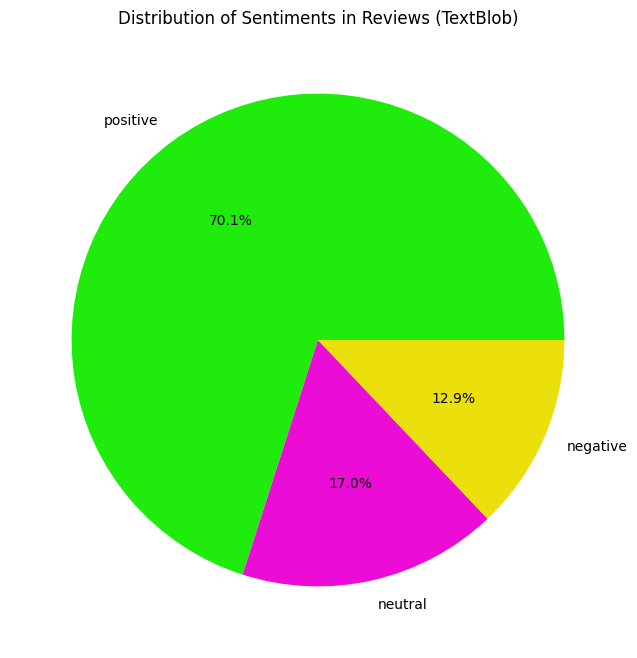

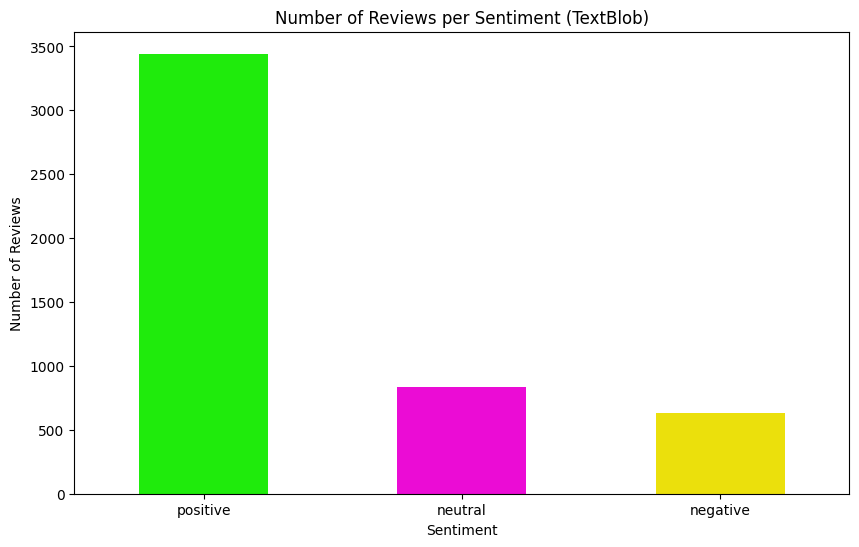

In [49]:
#Make pie chart and bar chart for the number of positive, negative and neutral reviews
sentiment_counts = df['textblob_category'].value_counts()

#Pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#1FEB0C', '#EB0CD5', '#EBE00C'])
plt.title('Distribution of Sentiments in Reviews (TextBlob)')
plt.show()

#Bar chart
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['#1FEB0C', '#EB0CD5', '#EBE00C'])
plt.title('Number of Reviews per Sentiment (TextBlob)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()